
Equipe 02
*   Abdessamed Seddiki
*   Hind Ledra
*  Ines Bouais
*   Lydia Mouhoun
*   Mohammed Arab
*   Serine Gheddou
*   Elamine Selmane

Groupe : SIQ2

TP: Recherche Locale

## **1-Methode de récuit simulé**

In [ ]:
import random
import math
import matplotlib.pyplot as plt
import numpy as np

def calculate_energy(bins_used, bin_capacity):
    total_bins = len(bins_used)
    total_capacity = total_bins * bin_capacity
    total_load = sum(sum(bin_content) for bin_content in bins_used)

    energy = total_bins * (total_bins - 1) * bin_capacity ** 2 - 2 * total_load * bin_capacity

    return energy

def generate_neighbor(bins_used, bin_capacity, temperature):
    num_bins = len(bins_used)
    if num_bins < 2:
        return bins_used

    new_bins_used = [bin_content.copy() for bin_content in bins_used]

    if temperature > 1000:
        # Choisir le type de mouvement en se basant sur la température
        move_type = 'relocation'
    else:
        move_type = 'exchange'

    if move_type == 'relocation':
        # mouvement par allocation
        bin_idx = random.randint(0, num_bins - 1)
        bin_content = new_bins_used[bin_idx]
        if bin_content:
            item_idx = random.randint(0, len(bin_content) - 1)
            item = bin_content[item_idx]

            dest_bin_idx = random.randint(0, num_bins - 1)
            while dest_bin_idx == bin_idx:
                dest_bin_idx = random.randint(0, num_bins - 1)

            dest_bin_content = new_bins_used[dest_bin_idx]

            current_bin_load = sum(bin_content) - item
            dest_bin_load = sum(dest_bin_content) + item
            current_bin_energy = abs(current_bin_load - bin_capacity) ** 2
            dest_bin_energy = abs(dest_bin_load - bin_capacity) ** 2
            new_energy = current_bin_energy + dest_bin_energy

            if dest_bin_load <= bin_capacity:
                dest_bin_content.append(item)
                bin_content.pop(item_idx)
                new_bins_used[bin_idx] = bin_content
                new_bins_used[dest_bin_idx] = dest_bin_content

    else:
        # mouvement par changement
        bin_idx1, bin_idx2 = random.sample(range(num_bins), 2)
        bin_content1 = new_bins_used[bin_idx1]
        bin_content2 = new_bins_used[bin_idx2]

        if bin_content1 and bin_content2:
            item1 = random.choice(bin_content1)
            item2 = random.choice(bin_content2)

            bin1_load = sum(bin_content1) - item1 + item2
            bin2_load = sum(bin_content2) - item2 + item1
            bin1_energy = abs(bin1_load - bin_capacity) ** 2
            bin2_energy = abs(bin2_load - bin_capacity) ** 2
            new_energy = bin1_energy + bin2_energy

            if bin1_load <= bin_capacity and bin2_load <= bin_capacity:
                bin_content1.remove(item1)
                bin_content2.remove(item2)
                bin_content1.append(item2)
                bin_content2.append(item1)
                new_bins_used[bin_idx1] = bin_content1
                new_bins_used[bin_idx2] = bin_content2

    new_bins_used = [bin_content for bin_content in new_bins_used if bin_content]

    return new_bins_used, new_energy

def simulated_annealing(initial_solution, bin_capacity, temperature, cooling_rate, stopping_temperature, max_iterations, stagnation_threshold, stagnation_iterations):
    current_solution = initial_solution
    current_cost = calculate_energy(initial_solution, bin_capacity)
    costs = [current_cost]
    choices = []
    iteration = 0
    last_cost = current_cost
    stagnation_count = 0

    while temperature > stopping_temperature and iteration < max_iterations and stagnation_count < stagnation_iterations:
        neighbor_solution, cost_difference = generate_neighbor(current_solution, bin_capacity, temperature)

        if cost_difference > 0:
            current_solution = neighbor_solution
        else:
            u = random.random() # nombre aléatoire entre 0 et 1
            if u < math.exp(-cost_difference / temperature):
                current_solution = neighbor_solution

        temperature *= cooling_rate
        current_cost = calculate_energy(current_solution, bin_capacity)
        costs.append(current_cost)
        iteration += 1

        if abs(current_cost - last_cost) < stagnation_threshold:
            stagnation_count += 1
        else:
            stagnation_count = 0

        last_cost = current_cost

    return current_solution, costs, choices


def generate_initial_solution(bin_items, bin_capacity):
    initial_solution = [[]]
    current_bin_index = 0

    for bin_item in bin_items:
        if sum(initial_solution[current_bin_index]) + bin_item <= bin_capacity:
            # Ajouter l'objet au bac courant s'il ya assez d'éspace
            initial_solution[current_bin_index].append(bin_item)
        else:
            # CCréer un nouveau bac et ajouter l'objet
            initial_solution.append([bin_item])
            current_bin_index += 1  # mouvement vers le nouveau bac

    return initial_solution


def read_data_from_file(filename):
    with open(filename, 'r') as file:
        num_bins = int(file.readline().strip())
        bin_capacity = int(file.readline().strip())
        items = []
        for line in file:
            items.extend(map(int, line.strip().split()))
        return num_bins, bin_capacity, items

if __name__ == "__main__":
    filename = 'benchmark100.txt'
    num_items, bin_capacity, items = read_data_from_file(filename)

    # Définition des valeurs à tester pour les paramètres variables
    variable_params = {
        'initial_temperature': [1000, 500000, 200000000000],
        'stagnation_threshold': [500, 1000, 2000],
        'max_iterations': [20000, 40000, 60000]
    }

    # Initialisation des paramètres fixes
    fixed_params = {
        'cooling_rate': 0.999,
        'stagnation_iterations': 100000,
        'stopping_temperature': 10
    }

    # Initialisation du dictionnaire pour stocker les résultats
    results = {}

    # Réalisation des essais pour chaque combinaison de paramètres variables
    for initial_temp in variable_params['initial_temperature']:
        for max_iter in variable_params['max_iterations']:
            for stagnation_thresh in variable_params['stagnation_threshold']:
                # Exécution du recuit simulé avec les paramètres variables et les autres paramètres fixes
                final_solution, _, _ = simulated_annealing(initial_solution, bin_capacity, initial_temp, **fixed_params, max_iterations=max_iter, stagnation_threshold=stagnation_thresh)
                results[(initial_temp, max_iter, stagnation_thresh)] = len(final_solution)

    # Affichage des résultats dans un tableau
    print("Tableau des résultats:")
    print("Température initiale\tMax Itérations\tStagnation Threshold\tNombre de bacs utilisés")
    for params, num_bins in results.items():
        print(f"{params[0]}\t{params[1]}\t{params[2]}\t{num_bins}")

    # Dessin du tableau
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(111, projection='3d')

    x = [params[0] for params in results.keys()]
    y = [params[1] for params in results.keys()]
    z = [params[2] for params in results.keys()]
    c = list(results.values())

    img = ax.scatter(x, y, z, c=c, cmap=plt.hot())
    fig.colorbar(img)
    ax.set_xlabel('Température initiale')
    ax.set_ylabel('Max Itérations')
    ax.set_zlabel('Stagnation Threshold')
    plt.title('Nombre de bacs utilisés en fonction des paramètres')
    plt.show()


    plt.figure(figsize=(10, 6))

    # Dessin du plot
    plt.subplot(2, 1, 1)
    plt.plot(costs)
    plt.xlabel('Iterations')
    plt.ylabel('Cost')
    plt.title('Evolution du coût pour la dernière solution pour voir l\'effet de la stagnation sur le nombre maximale d\itération')

    plt.tight_layout()
    plt.show()


FileNotFoundError: [Errno 2] No such file or directory: 'benchmark100.txt'

### **Explication de la solution proposée:**
- Génération de la solution initiale: consiste à parcourir chaque objet et à vérifier si le bac actuel peut le contenir ; si oui, l'objet est ajouté au bac, sinon, un nouveau bac est alloué. Cette approche garantit une distribution initiale équilibrée des objets dans les bacs disponibles, optimisant ainsi l'efficacité de la recherche locale.
- Génération du voisin: Lorsque la température est élevée, l'algorithme de recuit simulé priorise l'exploration de l'espace des solutions en utilisant des mouvements simples comme la relocation. À des températures plus basses, l'algorithme se concentre sur l'exploitation en utilisant des mouvements plus sophistiqués comme l'échange pour converger vers une solution optimale. Cette approche permet d'éviter les optima locaux lors de l'exploration initiale tout en favorisant une optimisation précise à mesure que la température diminue.
- Fonction objective: le coût de chaque déplacement est calculé en mesurant la différence d'espace restant entre la solution actuelle et la solution voisine, ce qui permet de guider la recherche vers des solutions plus optimales.
- Les paramètres utilisées dans la solution: **Température initiale**, **Température Finale**, **Taux de refroidissement**, **Seuil de stagnation**, **Nombre maximale d'itérations**.
- Choix initiale des paramètres: Les valeurs initiales des paramètres peuvent être choisies de manière conservatrice pour garantir une exploration suffisamment large de l'espace des solutions. Ensuite, les ajustements peuvent être basés sur l'observation des performances de l'algorithme, en modifiant progressivement les valeurs pour améliorer l'équilibre entre exploration et exploitation, tout en tenant compte des caractéristiques spécifiques du problème.

## **2-Recherche tabou avec Randm walk:**

Pour choisir les meilleurs parametres:

1.   Nombre d'itérations
2.   Taille de liste tabu \
Nous faisons ces deux experiences



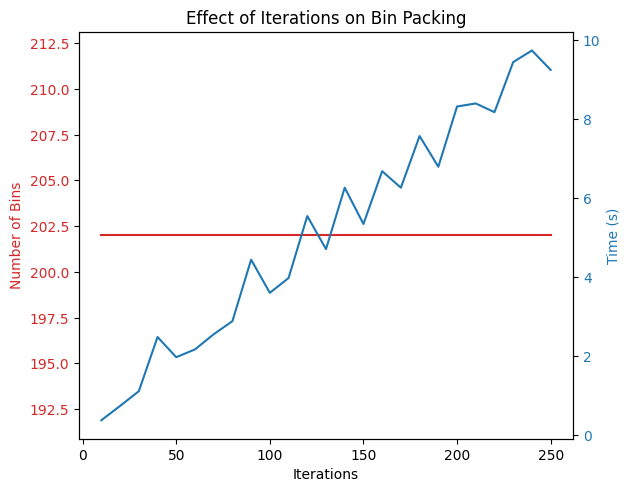

In [ ]:
# Effet de nombre d'itération sur le nombre de bins et e temps d'exécution
import random
import time
import matplotlib.pyplot as plt
def random_bin_packing(objets, capacite):
    bins = []  # Liste de conteneurs

    for objet in objets:
        placed = False
        random.shuffle(bins)  # Mélanger l'ordre des conteneurs à chaque itération

        for bin in bins:
            if sum(bin) + objet <= capacite:
                bin.append(objet)
                placed = True
                break

        if not placed:
            bins.append([objet])

    return bins

def read_objects_from_file(file_path):
    objects = []
    with open(file_path, 'r') as file:
        num_objects = int(file.readline().strip())
        bin_size = int(file.readline().strip())
        for _ in range(num_objects):
            obj_size = int(file.readline().strip())
            objects.append(obj_size)
    return num_objects, bin_size, objects

def recherche_tabou(file_path, iterations, taille_liste_tabou):
    num_objects, bin_size, objects = read_objects_from_file(file_path)
    meilleure_solution = None
    meilleure_nombre_conteneurs = float('inf')
    liste_tabou = []

    for _ in range(iterations):
        # Générer une solution avec la marche aléatoire
        solution = random_bin_packing(objects, bin_size)
        nombre_conteneurs = len(solution)

        # Vérifier si la solution est meilleure et non taboue
        if nombre_conteneurs < meilleure_nombre_conteneurs and solution not in liste_tabou:
            meilleure_solution = solution
            meilleure_nombre_conteneurs = nombre_conteneurs

        # Mettre à jour la liste tabou
        liste_tabou.append(solution)
        if len(liste_tabou) > taille_liste_tabou:
            liste_tabou.pop(0)  # Supprimer les anciennes solutions de la liste tabou

    return meilleure_solution, meilleure_nombre_conteneurs

file_path = 'benchmark500.txt'
max_iterations = 250
step = 10
taille_liste_tabou=10
results = []  # To store results for plotting

for iterations in range(10, max_iterations+1, step):
    start_time = time.time()
    meilleure_solution, meilleure_nombre_conteneurs = recherche_tabou(file_path, iterations, taille_liste_tabou)
    end_time = time.time()
    elapsed_time = end_time - start_time
    results.append((iterations, meilleure_nombre_conteneurs, elapsed_time))

# Plotting the results
iterations_list, bins_list, time_list = zip(*results)

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Iterations')
ax1.set_ylabel('Number of Bins', color=color)
ax1.plot(iterations_list, bins_list, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Time (s)', color=color)
ax2.plot(iterations_list, time_list, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title('Effect of Iterations on Bin Packing')
plt.show()
# donc entre 100 et 200 itérarions 150 donne ici un bon résulat

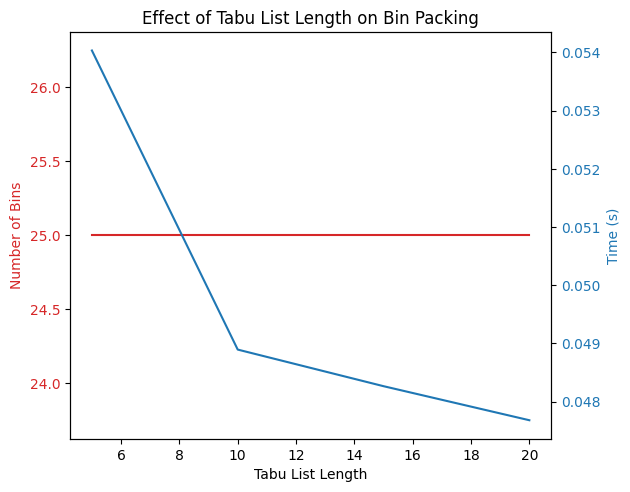

In [ ]:
# Effet de taille de liste tabou sur le nombre de bins et e temps d'exécution

import random
import time
import matplotlib.pyplot as plt
def random_bin_packing(objets, capacite):
    bins = []  # Liste de conteneurs

    for objet in objets:
        placed = False
        random.shuffle(bins)  # Mélanger l'ordre des conteneurs à chaque itération

        for bin in bins:
            if sum(bin) + objet <= capacite:
                bin.append(objet)
                placed = True
                break

        if not placed:
            bins.append([objet])

    return bins

def read_objects_from_file(file_path):
    objects = []
    with open(file_path, 'r') as file:
        num_objects = int(file.readline().strip())
        bin_size = int(file.readline().strip())
        for _ in range(num_objects):
            obj_size = int(file.readline().strip())
            objects.append(obj_size)
    return num_objects, bin_size, objects

def recherche_tabou(file_path, iterations, taille_liste_tabou):
    num_objects, bin_size, objects = read_objects_from_file(file_path)
    meilleure_solution = None
    meilleure_nombre_conteneurs = float('inf')
    liste_tabou = []

    for _ in range(iterations):
        # Générer une solution avec la marche aléatoire
        solution = random_bin_packing(objects, bin_size)
        nombre_conteneurs = len(solution)

        # Vérifier si la solution est meilleure et non taboue
        if nombre_conteneurs < meilleure_nombre_conteneurs and solution not in liste_tabou:
            meilleure_solution = solution
            meilleure_nombre_conteneurs = nombre_conteneurs

        # Mettre à jour la liste tabou
        liste_tabou.append(solution)
        if len(liste_tabou) > taille_liste_tabou:
            liste_tabou.pop(0)  # Supprimer les anciennes solutions de la liste tabou

    return meilleure_solution, meilleure_nombre_conteneurs

# Exemple d'utilisation
file_path = 'benchmark50.txt'
iterations = 100  # You can adjust this based on your needs
max_tabu_length = 20
step = 5

results = []  # To store results for plotting

for tabu_length in range(5, max_tabu_length+1, step):
    start_time = time.time()
    meilleure_solution, meilleure_nombre_conteneurs = recherche_tabou(file_path, iterations, tabu_length)
    end_time = time.time()
    elapsed_time = end_time - start_time
    results.append((tabu_length, meilleure_nombre_conteneurs, elapsed_time))

# Plotting the results
tabu_lengths, bins_list, time_list = zip(*results)

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Tabu List Length')
ax1.set_ylabel('Number of Bins', color=color)
ax1.plot(tabu_lengths, bins_list, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Time (s)', color=color)
ax2.plot(tabu_lengths, time_list, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title('Effect of Tabu List Length on Bin Packing')
plt.show()
# entre 10  15 solutions sera la taille de liste tabou, selon le banchmark

In [ ]:
# La solution
import random

def random_bin_packing(objets, capacite):
    bins = []  # Liste de conteneurs

    for objet in objets:
        placed = False
        random.shuffle(bins)  # Mélanger l'ordre des conteneurs à chaque itération

        for bin in bins:
            if sum(bin) + objet <= capacite:
                bin.append(objet)
                placed = True
                break

        if not placed:
            bins.append([objet])

    return bins

def read_objects_from_file(file_path):
    objects = []
    with open(file_path, 'r') as file:
        num_objects = int(file.readline().strip())
        bin_size = int(file.readline().strip())
        for _ in range(num_objects):
            obj_size = int(file.readline().strip())
            objects.append(obj_size)
    return num_objects, bin_size, objects

def recherche_tabou(file_path, iterations, taille_liste_tabou):
    num_objects, bin_size, objects = read_objects_from_file(file_path)
    meilleure_solution = None
    meilleure_nombre_conteneurs = float('inf')
    liste_tabou = []

    for _ in range(iterations):
        # Générer une solution avec la marche aléatoire
        solution = random_bin_packing(objects, bin_size)
        nombre_conteneurs = len(solution)

        # Vérifier si la solution est meilleure et non taboue
        if nombre_conteneurs < meilleure_nombre_conteneurs and solution not in liste_tabou:
            meilleure_solution = solution
            meilleure_nombre_conteneurs = nombre_conteneurs

        # Mettre à jour la liste tabou
        liste_tabou.append(solution)
        if len(liste_tabou) > taille_liste_tabou:
            liste_tabou.pop(0)  # Supprimer les anciennes solutions de la liste tabou

    return meilleure_solution, meilleure_nombre_conteneurs

# Exemple d'utilisation
file_path = 'benchmark50.txt'  # Mettez à jour avec votre chemin de fichier
iterations = 150
taille_liste_tabou = 5

meilleure_solution, meilleure_nombre_conteneurs = recherche_tabou(file_path, iterations, taille_liste_tabou)

print("\nMeilleure répartition trouvée après recherche tabou :")
for i, bin in enumerate(meilleure_solution):
    print(f"Conteneur {i+1} : {bin}")

print(f"\nNombre de conteneurs utilisés : {meilleure_nombre_conteneurs}")


### Explication de cette solution :

**Random_bin_packing:**
  Cette fonction implémente un algorithme de remplissage de bin aléatoire.
        
*   Il initialise une liste vide pour représenter les conteneurs.
*   Il parcourt chaque objet en essayant de le placer dans un bac. Si l'objet peut tenir dans un bac existant, il est ajouté à ce bac. Sinon, un nouveau bin est créé pour cet objet.


        

**Recherche_tabou**
 Cette fonction effectue un algorithme de recherche de tabu pour l'emballage de bin basé sur des solutions d'emballage de bin aléatoires.
        
*   Il lit la taille des objets et de la corbeille à partir du fichier à l'aide de read_objects_from_file.
*   Il initialise les variables pour suivre la meilleure solution (meilleure_solution) et le nombre de conteneurs utilisés (meilleure_nombre_conteneurs).

*   Il maintient une liste tabu (liste_tabou) pour éviter de revoir les solutions explorées précédemment.

*   Il exécute des itérations d'emballage aléatoire et évalue les solutions en fonction du nombre de conteneurs utilisés.

       
*  Il met à jour la meilleure solution si une nouvelle meilleure solution et non une solution est trouvée.
* Il retourne la meilleure solution et le nombre de conteneurs utilisés dans cette solution.

    

## **3-Recherche tabou avec best move**


In [ ]:
import time
# Read input from the benchmark file
def read_input(file_path):
    with open(file_path, 'r') as file:
        num_objects = int(file.readline().strip())
        bin_capacity = int(file.readline().strip())
        weights = [int(line.strip()) for line in file]

    return num_objects, bin_capacity, weights

file_path = 'benchmark500.txt'
num_objects, bin_capacity, weights = read_input(file_path)



def first_fit(items, capacite_bin):
    start_time = time.time()

    bins = []
    for item in items:
        assigne = False

        for bin in bins:
            if item <= bin['espace_libre']:
                bin['items'].append(item)
                bin['espace_libre'] -= item
                assigne = True
                break

        if not assigne:
            nouveau_bin = {'espace_libre': capacite_bin - item, 'items': [item]}
            bins.append(nouveau_bin)

    execution_time = time.time() - start_time

    return bins

def first_fit_decreasing(items, capacite_bin):
    items.sort(reverse=True)  # trier les éléments par taille, du plus grand au plus petit
    result=first_fit(items, capacite_bin)
    return result
def evaluate_solution(bins):
    # Evaluate the solution (objective function)
    # Objective: Minimize the number of bins used
    return len(bins)
def generate_neighbors(bins):
    # Generate neighboring solutions by swapping items between bins
    neighbors = []
    for i in range(len(bins)):
        for j in range(i + 1, len(bins)):
            for item_i in range(len(bins[i]['items'])):
                for item_j in range(len(bins[j]['items'])):
                    neighbor = [bin.copy() for bin in bins]  # Copy current solution
                    # Swap items between bins
                    neighbor[i]['items'].append(neighbor[j]['items'].pop(item_j))
                    neighbor[j]['items'].append(neighbor[i]['items'].pop(item_i))
                    neighbors.append(neighbor)
    return neighbors

def tabu_search(items, bin_capacity, iterations, tabu_size):
    start_time = time.time()
    current_solution = first_fit_decreasing(items,bin_capacity)
    best_solution = current_solution[:]
    tabu_list = []

    for _ in range(iterations):
        neighbors = generate_neighbors(current_solution)
        best_neighbor = None
        best_neighbor_value = float('inf')

        for neighbor in neighbors:
            if neighbor not in tabu_list:
                neighbor_value = evaluate_solution(neighbor)
                if neighbor_value < best_neighbor_value:
                    best_neighbor = neighbor
                    best_neighbor_value = neighbor_value

        if best_neighbor is None:
            break

        current_solution = best_neighbor[:]
        if evaluate_solution(current_solution) < evaluate_solution(best_solution):
            best_solution = current_solution[:]

        tabu_list.append(best_neighbor)
        if len(tabu_list) > tabu_size:
            tabu_list.pop(0)  # Remove oldest entry from tabu list
    end_time = time.time()
    execution_time = end_time - start_time
    return best_solution


best_solution = tabu_search(weights, bin_capacity, iterations=100, tabu_size=10)
print("Best solution found:", best_solution)
#print("Execution time:", execution_time)
print("Number of bins used:", evaluate_solution(best_solution))

### **Explication de cette solution**:

###  Première étape :
Définir l’heuristique qui génère la première solution (ici nous avons utilisé first fit decreasing)
### Deuxième étape :
 Définir la recherche Tabou en utilisant le meilleur mouvement (best move )comme stratégie de sélection de voisin
Cette fonction implémente l’algorithme de recherche de Tabu pour l’emballage de bin.
* Il commence par une solution initiale obtenue en utilisant first_fit_decreasing().
* Il itére à travers un nombre spécifié d’itérations, générant des voisins et sélectionnant le meilleur voisin qui ne figure pas dans la tabu_list.
* Il garde une trace de la meilleure solution trouvée et utilise une liste tabu pour éviter de revoir certaines solutions.
* Il retourne la meilleure solution trouvée en utilisant Tabu Search.

## **4-Hill climbing:**

In [ ]:
import random
def read_file(file_path):
    with open(file_path, 'r') as f:
        n = int(f.readline().strip())
        capacity = int(f.readline().strip())
        objects = [int(line.strip()) for line in f]
    return n,capacity, objects

def initial_solution(items, bin_capacity):
    items_sorted = sorted(items, reverse=True)
    bins = []
    for item in items_sorted:
        for bin_ in bins:
            if sum(bin_) + item <= bin_capacity:
                bin_.append(item)
                break
        else:
            bins.append([item])
    return bins

def evaluate_solution(bins):
    return len(bins)

def select_item_to_move(neighbor_solution):
    return random.choice([item for bin_ in neighbor_solution for item in bin_])

def find_destination_bin(neighbor_solution, item_to_move, bin_capacity):
    sorted_bins = sorted(neighbor_solution, key=lambda bin_: sum(bin_))
    for bin_ in sorted_bins:
        if sum(bin_) + item_to_move <= bin_capacity:
            return bin_
    return None

def hill_climbing(items, bin_capacity, max_iterations=1000):
    current_solution = initial_solution(items, bin_capacity)
    current_cost = evaluate_solution(current_solution)

    for _ in range(max_iterations):
        neighbor_solution = current_solution.copy()
        item_to_move = select_item_to_move(neighbor_solution)
        source_bin = next(bin_ for bin_ in neighbor_solution if item_to_move in bin_)

        destination_bin = find_destination_bin(neighbor_solution, item_to_move, bin_capacity)
        if destination_bin is not None:
            neighbor_solution.remove(source_bin)
            destination_bin.append(item_to_move)
          #  print("no destination bin found")
            continue



        neighbor_cost = evaluate_solution(neighbor_solution)

        if neighbor_cost < current_cost:
            current_solution = neighbor_solution
            current_cost = neighbor_cost

    return current_solution

n, bin_capacity,items = read_file("benchmark200.txt")

best_solution = hill_climbing(items, bin_capacity)
print("Best Solution:", best_solution)
print("Number of Bins Used:", len(best_solution))

Best Solution: [[69, 31], [69, 31], [69, 31], [69, 31], [69, 31], [69, 31], [67, 32], [67, 32], [67, 32], [67, 32], [67, 32], [67, 32], [67, 32], [67, 32], [67, 32], [67, 32], [67, 30], [67, 30], [65, 35], [65, 35], [65, 35], [65, 35], [64, 36], [64, 36], [62, 38], [62, 38], [61, 39], [61, 39], [61, 37], [61, 37], [60, 40], [60, 40], [60, 37], [60, 37], [59, 41], [59, 41], [58, 37], [58, 37], [57, 43], [57, 43], [57, 37], [57, 37], [56, 44], [56, 44], [56, 44], [56, 44], [55, 45], [55, 45], [55, 34, 11], [55, 34, 11], [55, 34, 11], [55, 34, 11], [55, 34, 11], [55, 34, 11], [55, 30, 15], [55, 30, 15], [54, 46], [54, 46], [54, 46], [54, 46], [53, 47], [53, 47], [52, 48], [52, 48], [52, 48], [52, 48], [52, 47], [52, 47], [49, 49], [29, 29, 29, 13], [29, 29, 29, 12], [28, 28, 28, 16], [28, 27, 27, 18], [26, 26, 25, 23], [25, 24, 24, 23], [23, 23, 22, 22], [22, 22, 22, 22, 12], [21, 21, 21, 21, 16], [18, 17, 17, 17, 17, 14], [16, 16, 15, 14, 12, 27]]
Number of Bins Used: 80
